Main factors explaining the pure number of migrants:
- Seasonality/Time of year pushes bird to depart for their journey. Several drivers might be at play from their internal clock, or sensing drop in temperature, day duration, food availbility, etc...
- Daily fluctation are mainly explained by weather condition favoring (or not) migration (wind speed/direction, thermal, visibility?) 
- Accumulation effect: bad weather for a couple of days pushes birds to migrates in larger number when weather becomes more favorable even though, it might not be the objectively best weather. 

Factor explaining not the pure number of migrating, but those seen and counted:
- Funneling point are probably affected by the ability of bird to migrates over barrier. For instance, under very good weather, they can migrates above the mountains while otherwise they would be funnel at the defile.
- - Detection error: weather affecting visibility, but also number of observer, skills of observers etc...

How to explain variation between years:
- Long-term fluctuation in number affected by population demography: climate change, distributation range, proportion of migrant in the population, habitat land use change etc...
- Short term fluctuation in the population affected by breeding success, juv survival
- Partial/facultative migration  
- Possible variation in the optimal route of migration effected by wind direction (e.g. migrating more west over france rather than in Switzerland because of west wind during the peak migration week).
- 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data"
years = range(1966, 2023)
doy = [196, 335]
species = "Common Buzzard"

In [3]:
# COUNT DATA ----------------------------
# Read data
df = pd.read_csv(
    data_dir + "/count/all_count_processed.csv",
    parse_dates=["date", "start", "end"],
)

# Filter data by years
df["doy"] = df["date"].dt.day_of_year
df["year"] = df["date"].dt.year
dfy = df[df["date"].dt.year.isin(years) & (df["doy"] >= doy[0]) & (df["doy"] <= doy[1])]

# Filter data by species and sum count of all species happening during the same period
data_count = (
    dfy[dfy.species == species][["date", "count", "start", "end"]]
    .groupby(["date", "start", "end"], as_index=False)["count"]
    .sum()
)
if len(data_count) == 0:
    raise ValueError(f"No data for species {species} in the selected years.")

# Build data.frame with the zero count
# Extract the dataframe with all period (regardless of the species)
df_all_period = dfy[
    [x for x in list(dfy) if x not in ["species", "count"]]
].drop_duplicates()

dfys = pd.merge(df_all_period, data_count, how="left")
# Replace NA (no match in data_count) with 0
dfys["count"] = dfys["count"].fillna(0)

# Add pre-cumputed variable
dfys["duration"] = dfys["end"] - dfys["start"]

# Create mask
# Corresponding to the fraction of each hour of the day during which the count in question has been happening
hours_mat = np.repeat(np.arange(24), len(dfys)).reshape(24, len(dfys))
startHour = dfys["start"].dt.hour.values + dfys["start"].dt.minute.values / 60
endHour = dfys["end"].dt.hour.values + dfys["end"].dt.minute.values / 60
tmp1 = np.maximum(np.minimum(hours_mat - startHour + 1, 1), 0)
tmp2 = np.maximum(np.minimum(endHour - hours_mat, 1), 0)
mask = np.minimum(tmp1, tmp2)

In [4]:
dfys["count_rate"] = dfys["count"] / (dfys["duration"] / np.timedelta64(1, "h"))

In [5]:
dfys.nlargest(10, "count_rate")

,date,start,end,doy,year,count,duration,count_rate
6115,2016-10-06,2016-10-06 10:00:00+00:00,2016-10-06 11:00:00+00:00,280,2016,1284.0,0 days 01:00:00,1284.000000
9964,2019-10-25,2019-10-25 12:00:00+00:00,2019-10-25 13:00:00+00:00,298,2019,1020.0,0 days 01:00:00,1020.000000
3168,2012-10-20,2012-10-20 16:00:00+00:00,2012-10-20 18:00:00+00:00,294,2012,1640.0,0 days 02:00:00,820.000000
3163,2012-10-15,2012-10-15 06:00:00+00:00,2012-10-15 17:00:00+00:00,289,2012,8857.0,0 days 11:00:00,805.181818
6381,2016-11-03,2016-11-03 11:00:00+00:00,2016-11-03 12:00:00+00:00,308,2016,784.0,0 days 01:00:00,784.000000
11194,2020-10-14,2020-10-14 11:00:00+00:00,2020-10-14 12:00:00+00:00,288,2020,771.0,0 days 01:00:00,771.000000
8606,2018-10-22,2018-10-22 13:00:00+00:00,2018-10-22 14:00:00+00:00,295,2018,705.0,0 days 01:00:00,705.000000
12420,2021-10-10,2021-10-10 12:00:00+00:00,2021-10-10 13:00:00+00:00,283,2021,683.0,0 days 01:00:00,683.000000
6116,2016-10-06,2016-10-06 11:00:00+00:00,2016-10-06 12:00:00+00:00,280,2016,631.0,0 days 01:00:00,631.000000
6117,2016-10-06,2016-10-06 12:00:00+00:00,2016-10-06 13:00:00+00:00,280,2016,613.0,0 days 01:00:00,613.000000


<Axes: >

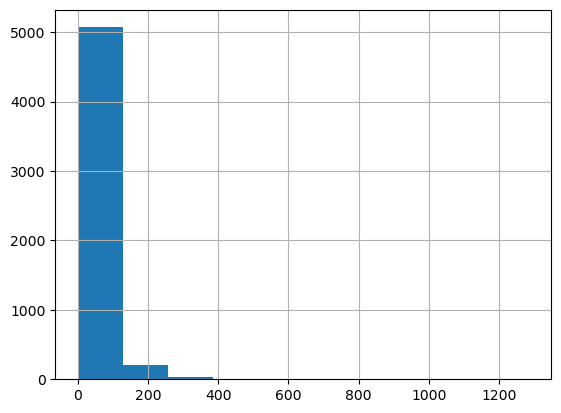

In [6]:
dfys.loc[dfys["count_rate"] > 0, "count_rate"].hist()

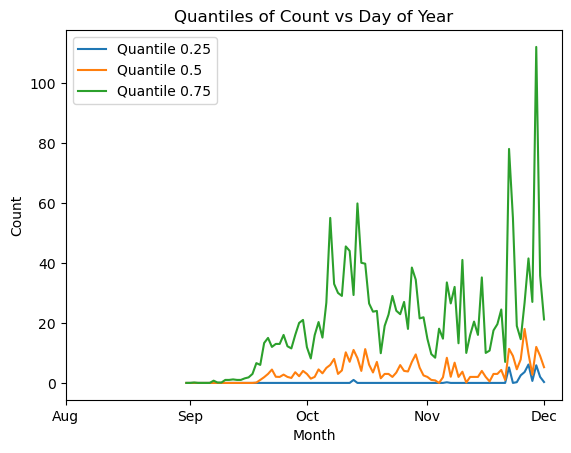

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the quantiles you want to plot
quantiles_to_plot = [0.25, 0.5, 0.75]

# doy_lim = [150, 280]
doy_lim = [243, 370]
# Filter data to only include 1st Oct (DOY 274) to 1st Dec (DOY 335)
# df_filtered = dfys[(dfys["doy"] >= 243) & (dfys["doy"] <= 340)]
df_filtered = dfys[(dfys["doy"] >= doy_lim[0]) & (dfys["doy"] <= doy_lim[1])]

# Group by DOY and calculate the quantiles
quantiles = (
    df_filtered.groupby("doy")["count_rate"].quantile(quantiles_to_plot).unstack()
)

# Plot each quantile for the DOY range
for quantile in quantiles_to_plot:
    plt.plot(quantiles.index, quantiles[quantile], label=f"Quantile {quantile}")

# Customize the x-axis to show months and days
plt.xticks(ticks=[212, 244, 274, 305, 335], labels=["Aug", "Sep", "Oct", "Nov", "Dec"])

# Customize the plot
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Quantiles of Count vs Day of Year")
plt.legend()
plt.show()

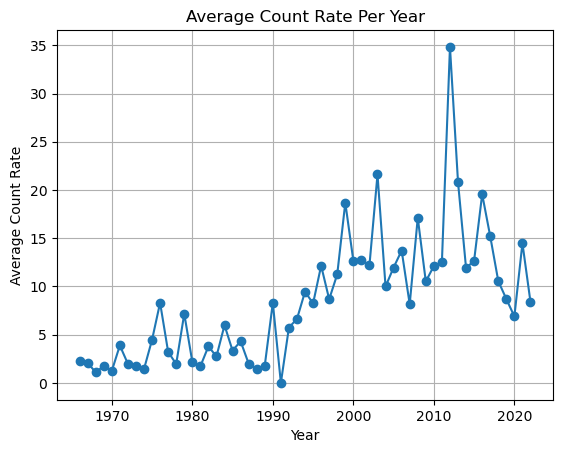

In [8]:
# Assuming you have a 'date' column in datetime format
dfys["year"] = dfys["date"].dt.year

# Group by year and calculate the average count_rate
average_count_rate = dfys.groupby("year")["count_rate"].mean()

# Plot the average count rate for each year
plt.plot(average_count_rate.index, average_count_rate.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Average Count Rate")
plt.title("Average Count Rate Per Year")
plt.grid(True)
plt.show()

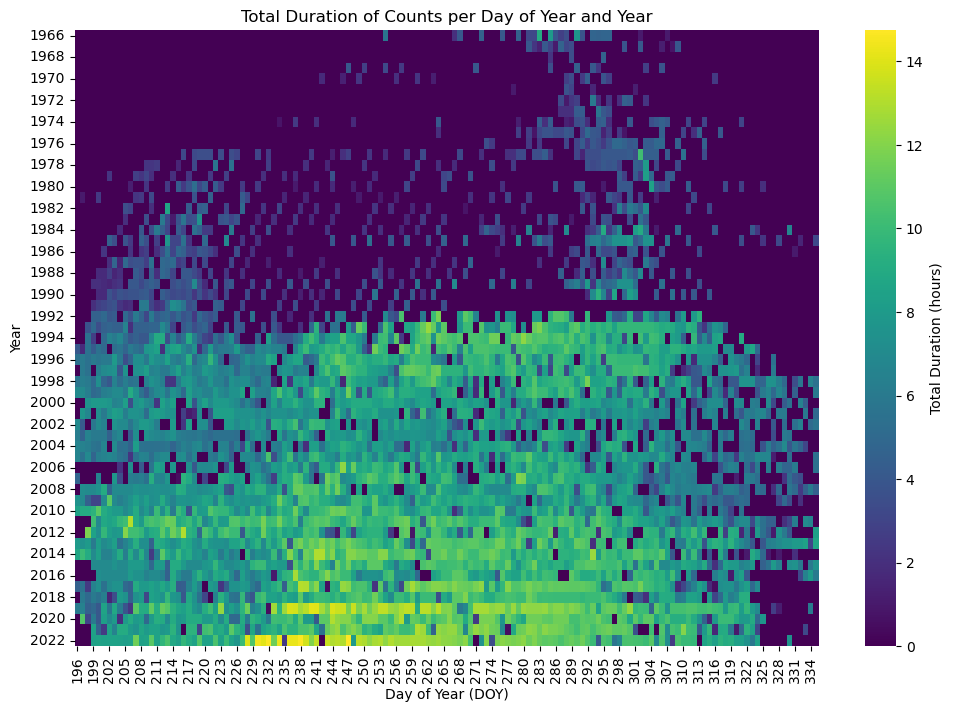

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data for demonstration
# dfys = pd.DataFrame({
#     'year': [1990, 1990, 1991, 1991],
#     'doy': [1, 2, 1, 2],
#     'duration': [pd.Timedelta(hours=1), pd.Timedelta(hours=2), pd.Timedelta(hours=1.5), pd.Timedelta(hours=1)]
# })

# Ensure the 'duration' is in hours
dfys["duration_hours"] = dfys["duration"].dt.total_seconds() / 3600  # Convert to hours

# Step 1: Aggregate the total duration for each day of the year per year
heatmap_data = (
    dfys.groupby(["year", "doy"])["duration_hours"].sum().unstack(fill_value=0)
)

# Step 2: Create the heatmap using sns.heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={"label": "Total Duration (hours)"})

# Step 3: Customize the plot
plt.title("Total Duration of Counts per Day of Year and Year")
plt.xlabel("Day of Year (DOY)")
plt.ylabel("Year")
plt.yticks(rotation=0)  # Rotate y-ticks for better readability


plt.show()

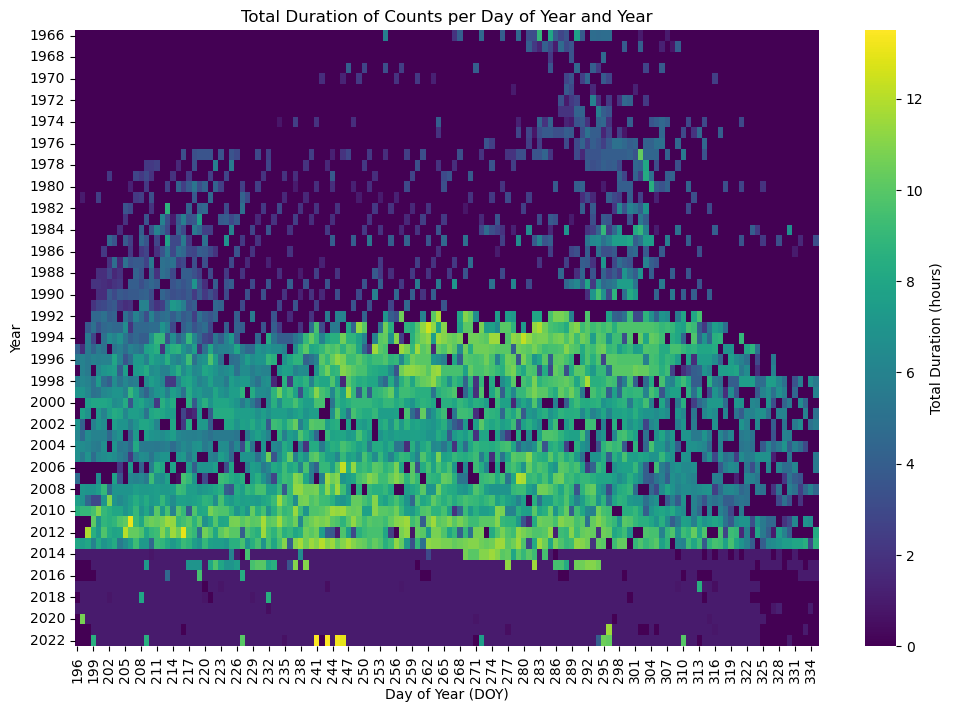

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data for demonstration
# dfys = pd.DataFrame({
#     'year': [1990, 1990, 1991, 1991],
#     'doy': [1, 2, 1, 2],
#     'duration': [pd.Timedelta(hours=1), pd.Timedelta(hours=2), pd.Timedelta(hours=1.5), pd.Timedelta(hours=1)]
# })

# Ensure the 'duration' is in hours
dfys["duration_hours"] = dfys["duration"].dt.total_seconds() / 3600  # Convert to hours

# Step 1: Aggregate the total duration for each day of the year per year
heatmap_data = (
    dfys.groupby(["year", "doy"])["duration_hours"].median().unstack(fill_value=0)
)

# Step 2: Create the heatmap using sns.heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="viridis", cbar_kws={"label": "Total Duration (hours)"})

# Step 3: Customize the plot
plt.title("Total Duration of Counts per Day of Year and Year")
plt.xlabel("Day of Year (DOY)")
plt.ylabel("Year")
plt.yticks(rotation=0)  # Rotate y-ticks for better readability


plt.show()

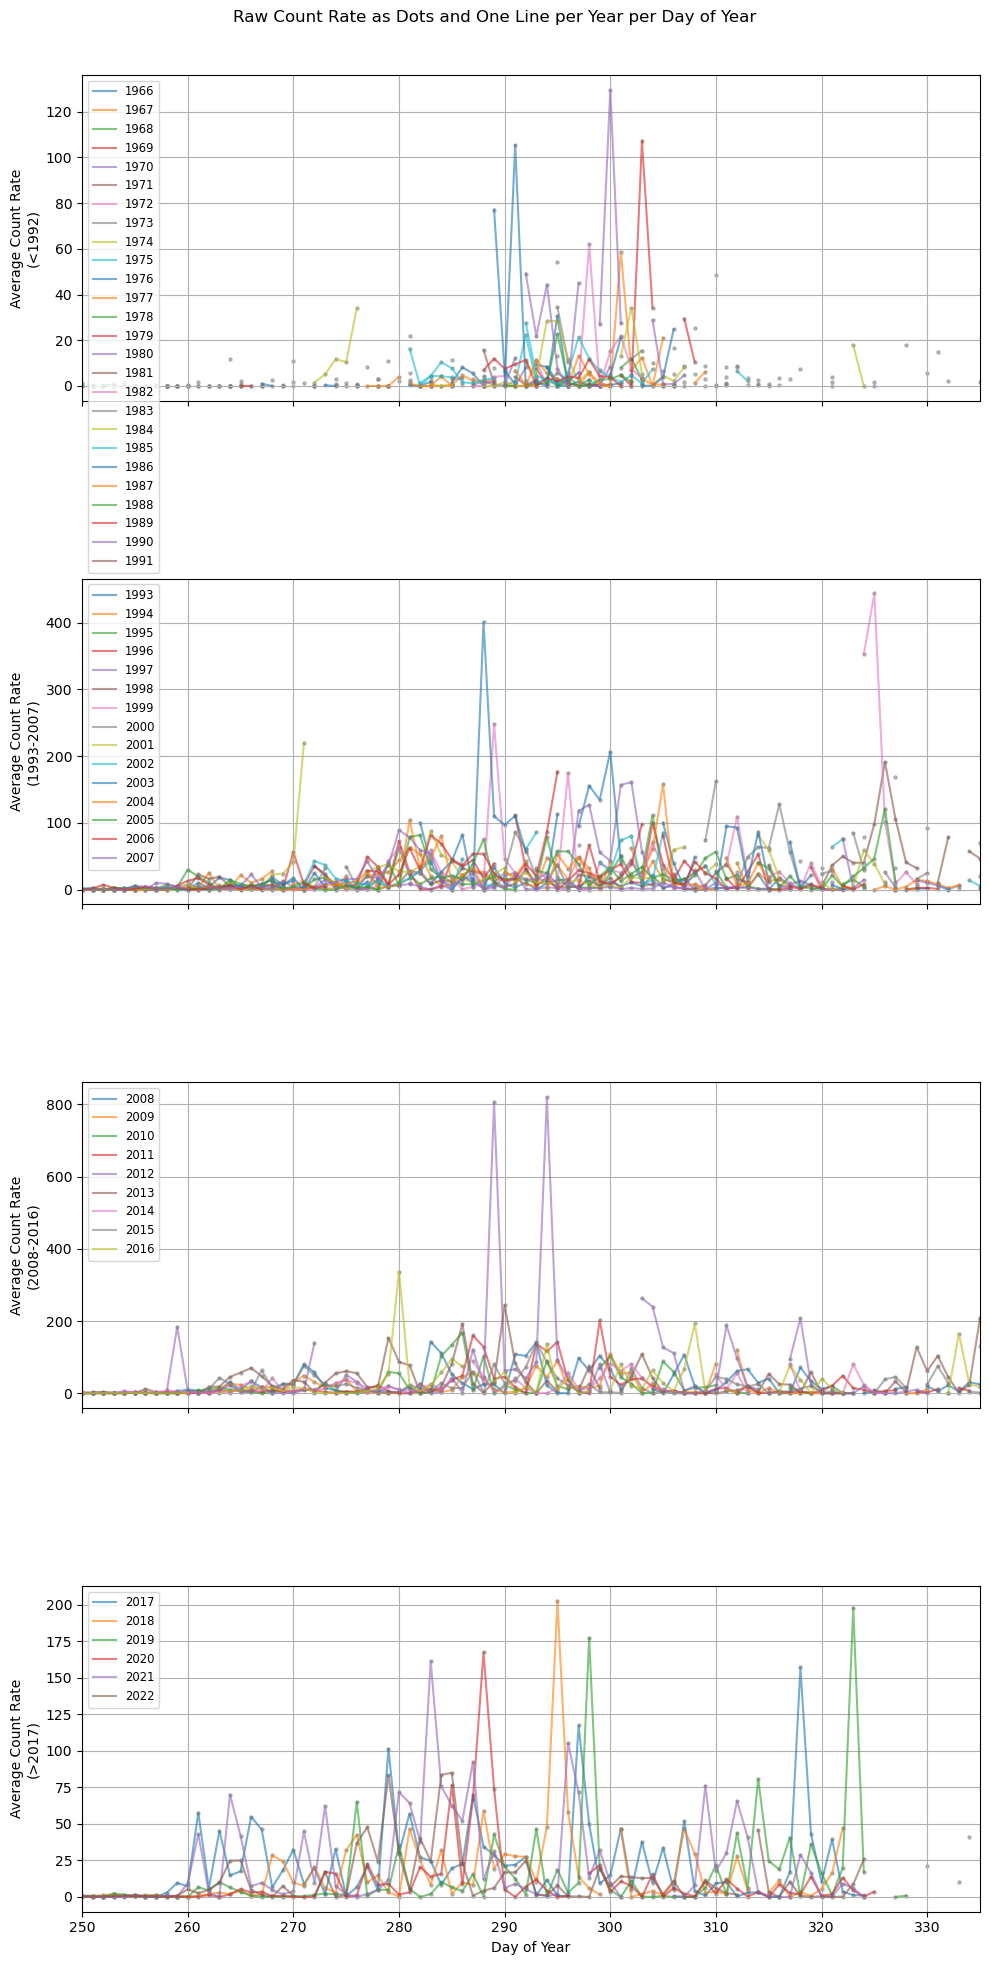

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Group by both 'year' and 'DOY', then calculate the average count_rate for each group
average_count_rate = dfys.groupby(["year", "doy"])["count_rate"].mean().unstack()

# Manually define the periods and group years accordingly
periods = {
    "<1992": average_count_rate.index[average_count_rate.index < 1992],
    "1993-2007": average_count_rate.index[
        (average_count_rate.index >= 1993) & (average_count_rate.index <= 2007)
    ],
    "2008-2016": average_count_rate.index[
        (average_count_rate.index >= 2008) & (average_count_rate.index <= 2016)
    ],
    ">2017": average_count_rate.index[average_count_rate.index >= 2017],
}

# Create subplots: One subplot for each time period
n_groups = len(periods)
fig, axes = plt.subplots(n_groups, 1, figsize=(10, 5 * n_groups), sharex=True)

# If there's only one group, `axes` will not be a list
if n_groups == 1:
    axes = [axes]

# Plot each group of years (by period)
for i, (period, years) in enumerate(periods.items()):
    # Raw data (individual count_rate for each day)
    for year in years:
        # Scatter plot for raw count_rate
        axes[i].scatter(
            average_count_rate.columns,
            average_count_rate.loc[year],
            color="gray",
            alpha=0.5,
            s=5,
            label="_nolegend_",
        )

        # Line plot for each year's count_rate
        axes[i].plot(
            average_count_rate.columns,
            average_count_rate.loc[year],
            label=f"{year}",
            alpha=0.6,
        )

    # Labeling and layout
    axes[i].set_ylabel(f"Average Count Rate\n({period})")
    axes[i].grid(True)
    axes[i].legend(loc="upper left", fontsize="small")

# Customize x-axis for all subplots
plt.xlabel("Day of Year")
plt.suptitle("Raw Count Rate as Dots and One Line per Year per Day of Year")
plt.xlim(250, average_count_rate.columns.max())
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout for title

plt.show()